In [1]:
# NEED TO USE predictors_simple kernel to be able to load the modles
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns


import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/scripts")
from Model import ADModel_act, ADModel_abund
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/PADDLE")

import paddle
import os

os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [138]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [ ]:
# READING IN FULL LENGTH VALIDATION SEQUENCES AND TILE DATA

data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Unique_502_Gcn4_Seqs.csv", index_col=0)
val_seqs= data[data["heirarchical"] == 1]
train_seqs = data[data["heirarchical"] != 1]

tile_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile --> BUGGG ADDS FINAL TILE TWICE!!
val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]


train_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in train_seqs["Sequence"]]
train_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_22800/898701878.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_22800/898701878.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]
/var/folders/34/1p

In [148]:
# BIOPHYSICAL MODEL STUFF
import torch

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 30
outchannel = 1
model = "model_data/simple_abundmodel_b10_e200_L0.0001_sMinMax_c1_k30_wp0.1_ParaReLU_hSplit_seed7468236_weightInit"
biophysical_model = ADModel_abund(size,kernel_size)
biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

biophysical_model.eval()
sc_abund = load("scripts/scaler_abund.bin")

def run_biophysical_model(loaded_model,sequence):
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = sc_abund.inverse_transform(predictions.detach().numpy().reshape(1, -1))
    return predictions

val_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred"] = [run_biophysical_model(biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]


/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_22800/372232508.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/

In [141]:
# ADHUNTER STUFF
kernel_size = 5
dilation = 3 
hidden = 64

gfp_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
gfp_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_gfp.pt"))
gfp_model.eval()

mcherry_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
mcherry_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_cherry.pt"))
mcherry_model.eval()

sc_gfp=load('../../../tools_software/adhunter/scaler_gfp.pkl')
sc_mcherry=load('../../../tools_software/adhunter/scaler_cherry.pkl')

alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

def run_adhunter(model, sequence, sc):
    X = np.asarray([[aa_to_i[aa] for aa in sequence]])
    X = torch.tensor(X)
    result = model(X)
    result = sc.inverse_transform(result.detach().numpy().reshape(-1, 1))
    return result[0,0]


# Predict ADHunter score for each 40aa tile in the validation data set
val_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["adhunter_mcherry_pred"] = [[run_adhunter(mcherry_model, tile, sc_mcherry) for tile in tiles] for tiles in val_seqs["40_tiles"]]

other_tiles["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in other_tiles["aa_seq"]]
other_tiles["adhunter_mcherry_pred"] = [run_adhunter(mcherry_model, tile, sc_mcherry) for tile in other_tiles["aa_seq"]]

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_22800/1321588379.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in val_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_22800/1321588379.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


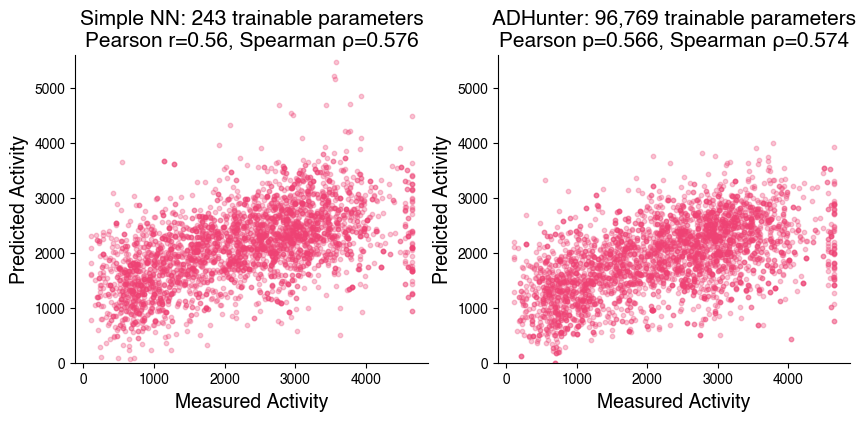

In [157]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in val_seqs["biophysics_mcherry_pred"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 5600)
axs[0].set_title(f'Simple NN: 243 trainable parameters\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in val_seqs["adhunter_mcherry_pred"] for i in ls]
pred = pred + (list(other_tiles["adhunter_mcherry_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1]
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 5600)
axs[1].set_title(f'ADHunter: 96,769 trainable parameters\nPearson p={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()
# plt.savefig(f"{outdir}/scatter_plots.pdf")
plt.savefig("figures/simple_abund_scatter_plots.pdf", format='pdf', bbox_inches='tight')

# Make convolution filter plots

In [144]:
def load_model(name, k):
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

In [34]:
model_15_name = "model_data/simple_abundmodel_b10_e200_L0.0001_sMinMax_c1_k15_wp0.1_ParaReLU_hSplit_seed82376068_weightInit"
model_15 = load_model(model_15_name, 15)

In [35]:
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


In [43]:
def make_row_plot(fig, kernel_size, model, row, lim, height_ratios, num_rows):

    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

In [26]:
# Red often represents negative charges
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


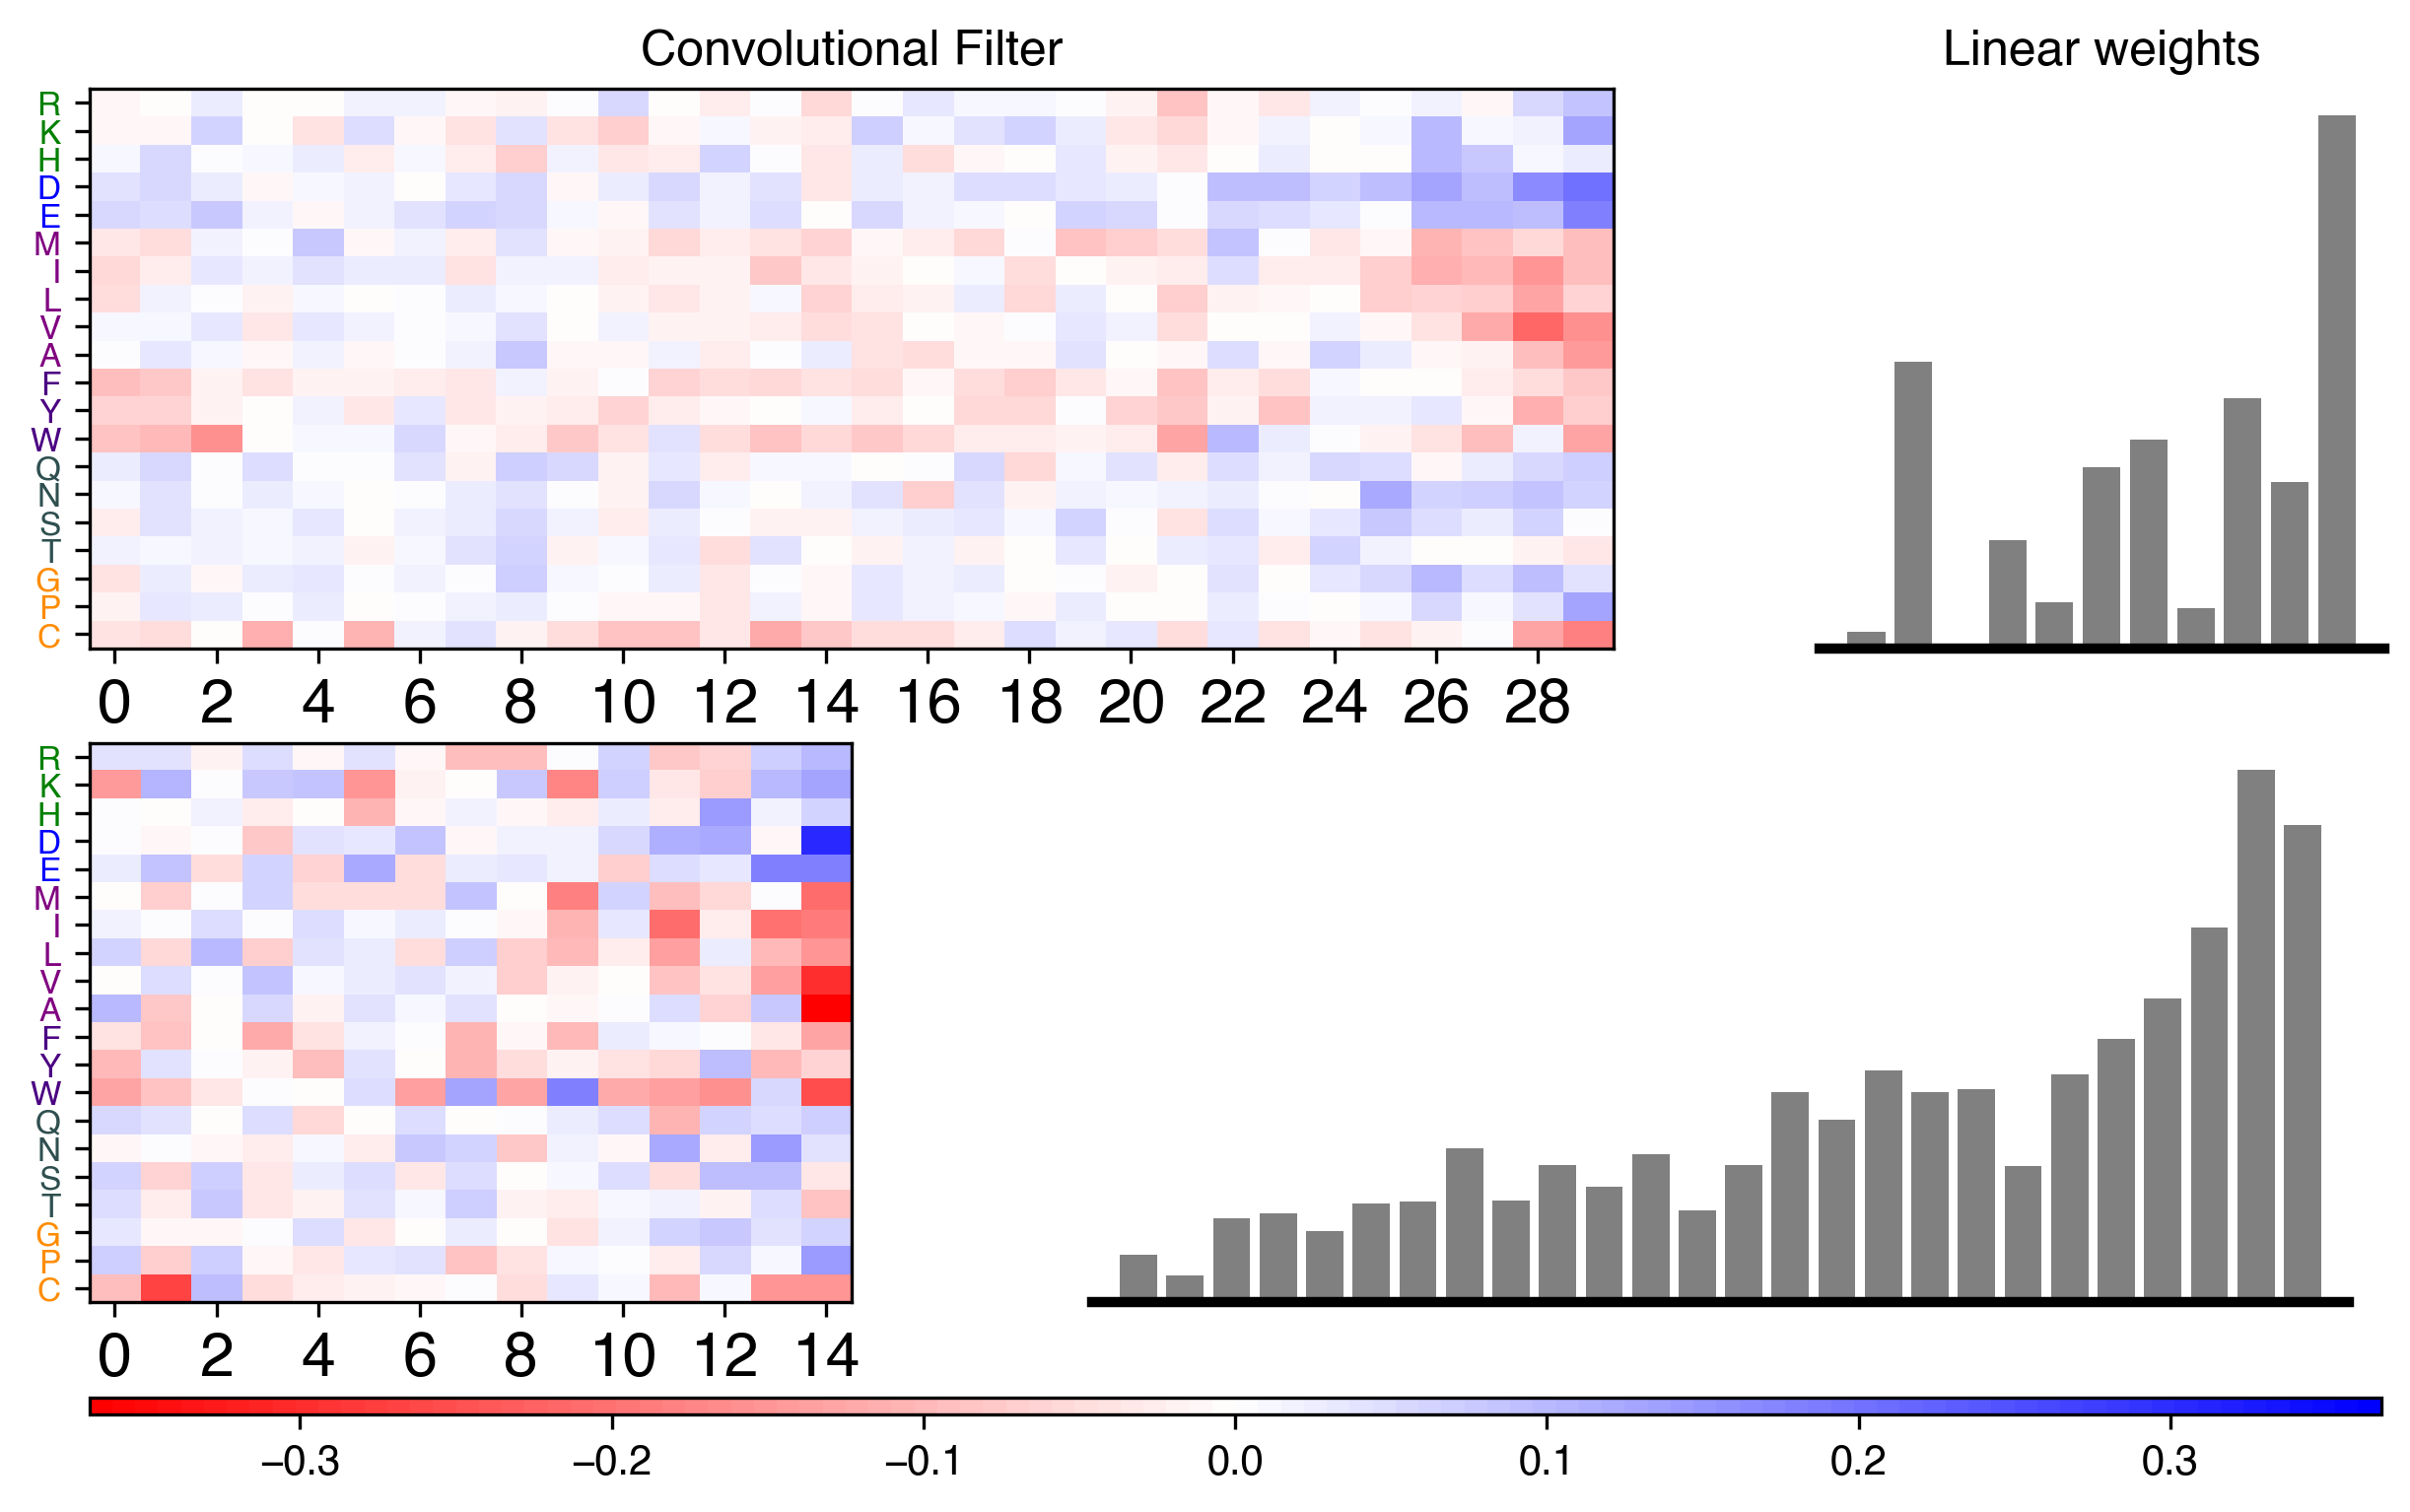

In [ ]:
num_rows = 2
models = [model_15, biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
# ax1.set_title("Features predicting GFP expression", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 30, biophysical_model, 1, lim, height_ratios, num_rows)
ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

ax1, ax2, im1 = make_row_plot(fig, 15, model_15, 3, lim, height_ratios, num_rows)



gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("figures/simple_abund_parameters.pdf", format='pdf', bbox_inches='tight')


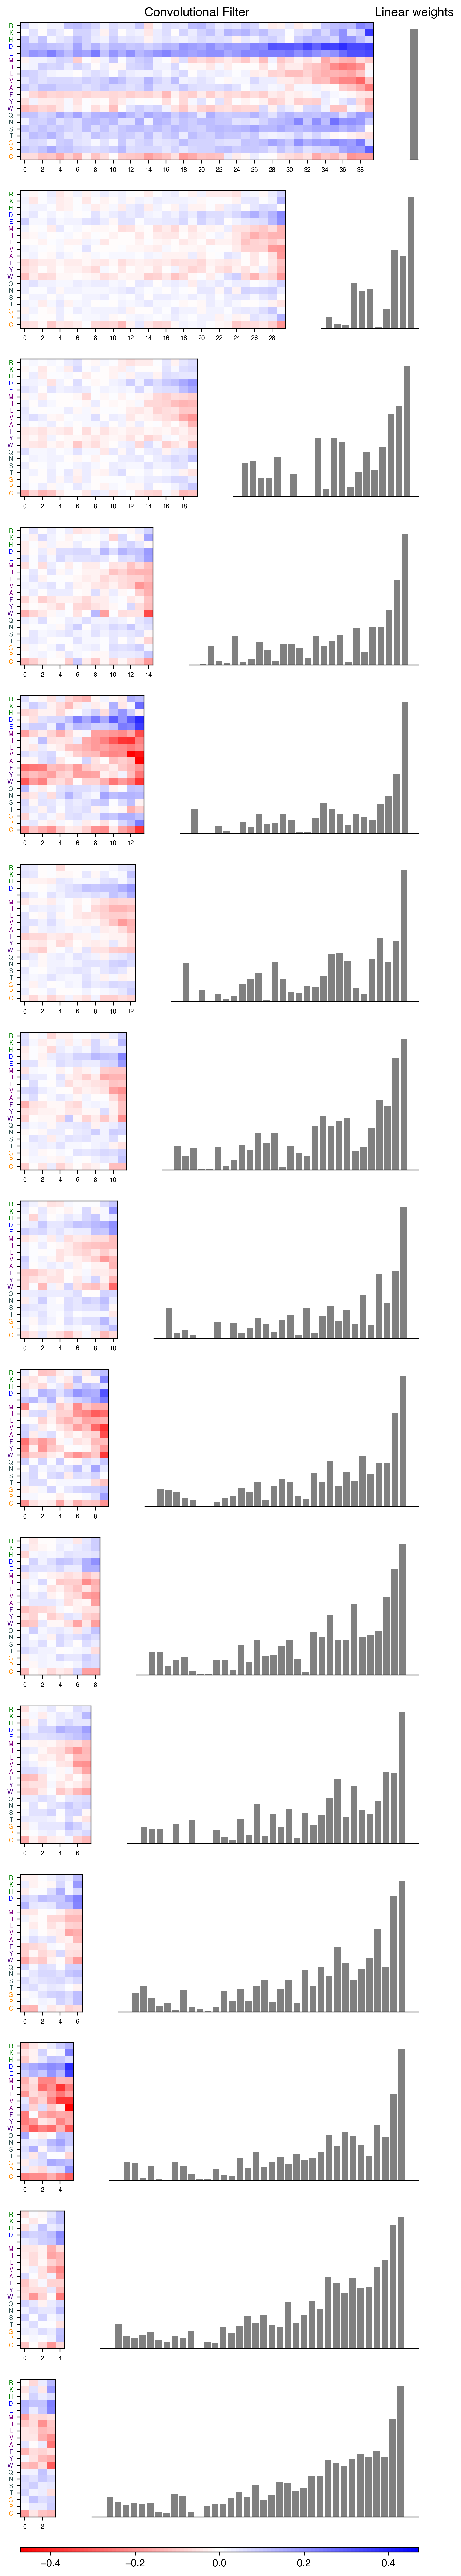

In [27]:
num_rows = 15
models = [model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11, model_12, model_13, model_14, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(7, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3, .1]*num_rows + [.1]

gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax1, ax2, im1 = make_row_plot(fig, 40, model_40, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)


make_row_plot(fig, 4, model_4, 29, lim, height_ratios, num_rows)
make_row_plot(fig, 5, model_5, 27, lim, height_ratios, num_rows)
make_row_plot(fig, 6, model_6, 25, lim, height_ratios, num_rows)
make_row_plot(fig, 7, model_7, 23, lim, height_ratios, num_rows)
make_row_plot(fig, 8, model_8, 21, lim, height_ratios, num_rows)
make_row_plot(fig, 9, model_9, 19, lim, height_ratios, num_rows)
make_row_plot(fig, 10, model_10, 17, lim, height_ratios, num_rows)
make_row_plot(fig, 11, model_11, 15, lim, height_ratios, num_rows)
make_row_plot(fig, 12, model_12, 13, lim, height_ratios, num_rows)
make_row_plot(fig, 13, model_13, 11, lim, height_ratios, num_rows)
make_row_plot(fig, 14, model_14, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 15, model_15, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 20, model_20, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 30, model_30, 3, lim, height_ratios, num_rows)


gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])


# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')


# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.png', dpi=1000, bbox_inches='tight')

# Make histograms of abundance

In [2]:
data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

In [3]:
positives = ["R", "K"]
negatives = ["D", "E"]

hydrophobics = ["M", "I", "L", "V", "A", "F", "Y", "W"]
aromatics = ["W", "F", "Y"]

In [4]:
def contains_three_hydrophobics(seq):
    for i in range(len(seq)-2):
        if seq[i] in hydrophobics:
            if seq[i+1] in hydrophobics:
                if seq[i+2] in hydrophobics:
                    return True
    return False

def contains_two_hydrophobics(seq):
    for i in range(len(seq)-1):
        if seq[i] in hydrophobics:
            if seq[i+1] in hydrophobics:
                return True
    return False


def contains_one_hydrophobics(seq):
    for i in range(len(seq)):
        if seq[i] in hydrophobics:
            return True
    return False

In [5]:
data["ends_w_charge"] = [(s[-1] in positives) | (s[-1] in negatives) for s in data["aa_seq"]]
data["ends_w_negative"] = [(s[-1] in negatives) for s in data["aa_seq"]]
data["ends_w_positive"] = [(s[-1] in positives) for s in data["aa_seq"]]

data["ends_w_hydrophobic"] = [(s[-1] in hydrophobics) for s in data["aa_seq"]]

data["ends_w_two_charge"] = [((s[-1] in positives) | (s[-1] in negatives)) & ((s[-2] in positives) | (s[-2] in negatives)) for s in data["aa_seq"]]
data["ends_w_two_hydrophobic"] = [(s[-1] in hydrophobics) & (s[-2] in hydrophobics) for s in data["aa_seq"]]


data["ends_w_three_charge"] = [((s[-1] in positives) | (s[-1] in negatives)) & ((s[-2] in positives) | (s[-2] in negatives)) & ((s[-3] in positives) | (s[-3] in negatives)) for s in data["aa_seq"]]
data["ends_w_three_hydrophobic"] = [(s[-1] in hydrophobics) & (s[-2] in hydrophobics) & (s[-3] in hydrophobics) for s in data["aa_seq"]]

data["total_charge"] = [s.count(positives[0]) + s.count(positives[1]) + s.count(negatives[0]) + s.count(negatives[1]) for s in data["aa_seq"]]
data["total_negatives"] = [s.count(negatives[0]) + s.count(negatives[1]) for s in data["aa_seq"]]

data["total_positives"] = [s.count(positives[0]) + s.count(positives[1]) for s in data["aa_seq"]]

data["total_hydrophobics"] = [s.count(hydrophobics[0]) + s.count(hydrophobics[1]) + s.count(hydrophobics[2]) + s.count(hydrophobics[3]) + s.count(hydrophobics[4]) + s.count(hydrophobics[5]) + s.count(hydrophobics[6]) + s.count(hydrophobics[7]) for s in data["aa_seq"]]
data["total_aromatics"] = [s.count(aromatics[0]) + s.count(aromatics[1]) + s.count(aromatics[2]) for s in data["aa_seq"]]


data["contains_three_hydrophobic"] = [contains_three_hydrophobics(s) for s in data["aa_seq"]]
data["contains_two_hydrophobic"] = [contains_two_hydrophobics(s) for s in data["aa_seq"]]
data["contains_hydrophobic"] = [contains_one_hydrophobics(s) for s in data["aa_seq"]]

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_52407/33096939.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_charge"].unique()), patch_artist=True)


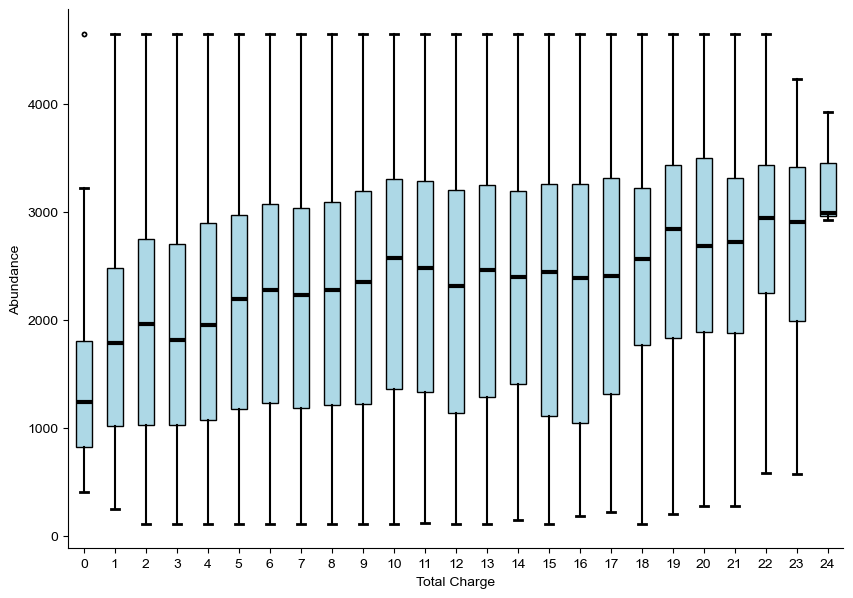

In [6]:
grouped_data = [data[data["total_charge"] == charge]["abundance"] for charge in sorted(data["total_charge"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_charge"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_charge"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("lightblue")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Charge")
ax.set_ylabel("Abundance")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_52407/2264176943.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_negatives"].unique()), patch_artist=True)


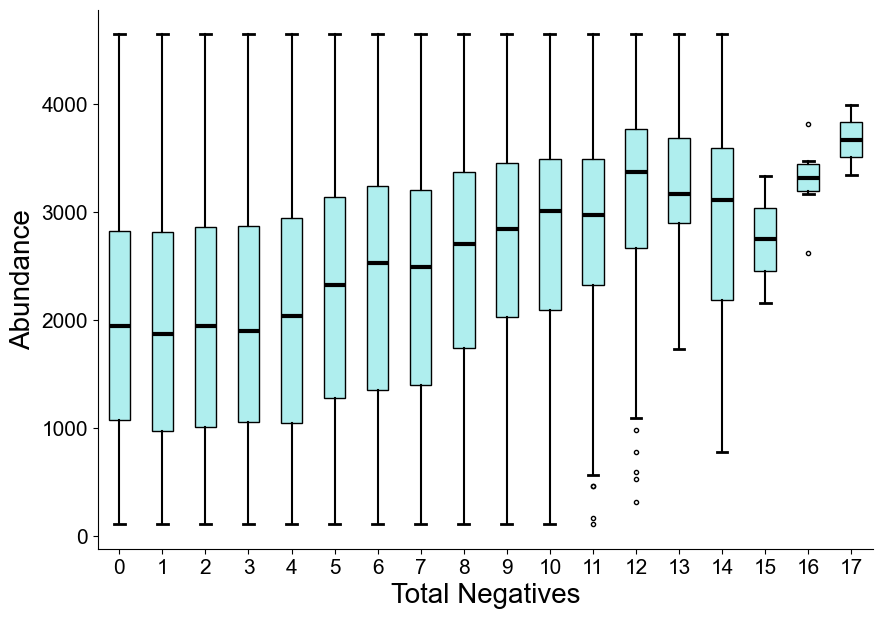

In [7]:
grouped_data = [data[data["total_negatives"] == charge]["abundance"] for charge in sorted(data["total_negatives"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_negatives"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_negatives"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("paleturquoise")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Negatives", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_negative.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_52407/3666665809.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_positives"].unique()), patch_artist=True)


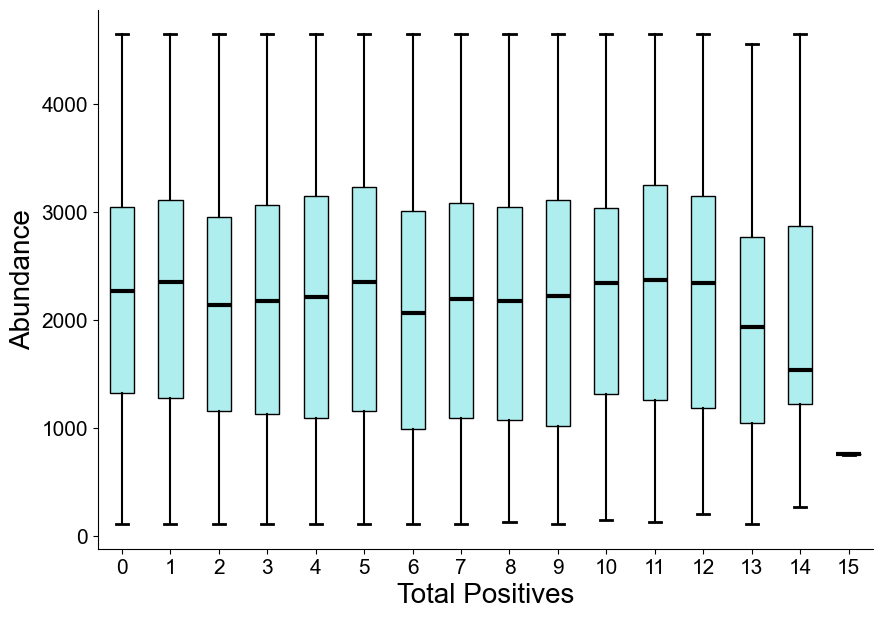

In [8]:
grouped_data = [data[data["total_positives"] == charge]["abundance"] for charge in sorted(data["total_positives"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_positives"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_positives"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("paleturquoise")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Positives", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_positive.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_52407/1569290240.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_hydrophobics"].unique()), patch_artist=True)


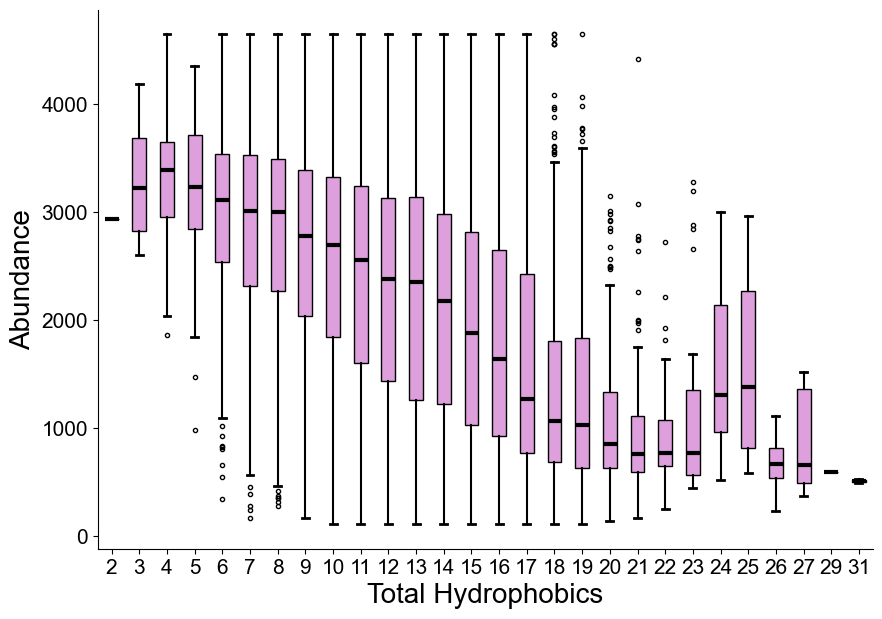

In [9]:
grouped_data = [data[data["total_hydrophobics"] == charge]["abundance"] for charge in sorted(data["total_hydrophobics"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_hydrophobics"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_hydrophobics"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("plum")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Hydrophobics", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_hydrophobic.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_52407/953215411.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_aromatics"].unique()), patch_artist=True)


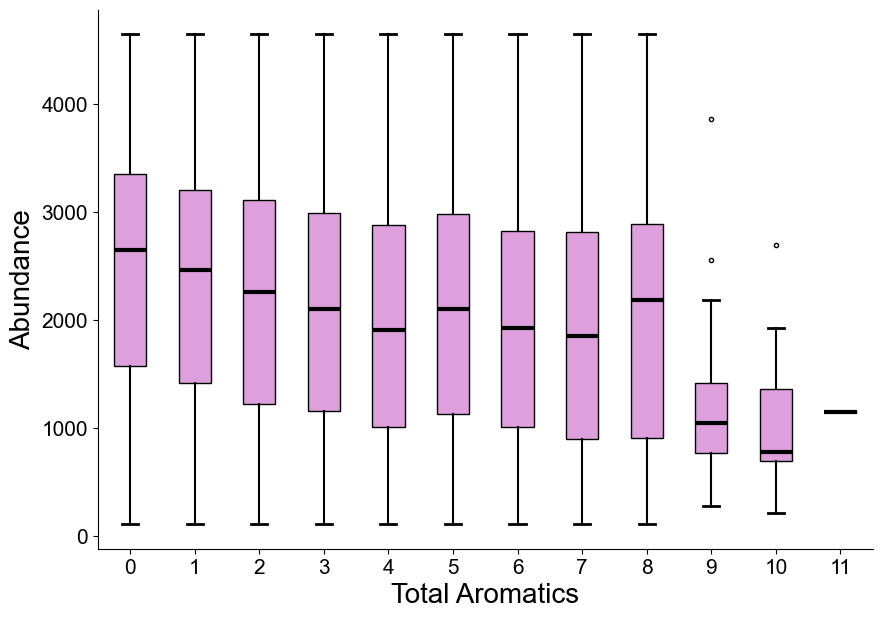

In [10]:
grouped_data = [data[data["total_aromatics"] == charge]["abundance"] for charge in sorted(data["total_aromatics"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_aromatics"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_aromatics"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("plum")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Aromatics", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig("figures/abundance_barplot_hydrophobic.pdf", format='pdf', bbox_inches='tight')


In [11]:
data[["ends_w_two_hydrophobic", "contains_two_hydrophobic"]].value_counts()

ends_w_two_hydrophobic  contains_two_hydrophobic
False                   True                        15534
True                    True                         1898
False                   False                         300
Name: count, dtype: int64

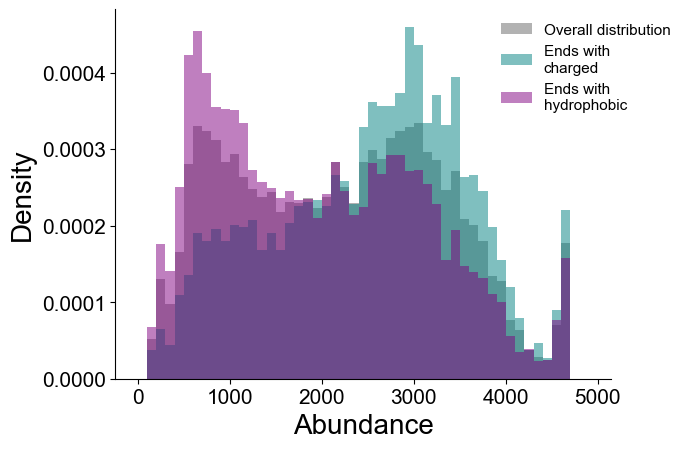

In [26]:
bins = np.arange(0, 5000, 100)
plt.hist(data["abundance"], density=True, alpha=0.3, bins=bins, color="black", label="Overall distribution")

plt.hist(data[data["ends_w_charge"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \ncharged")
plt.hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \nhydrophobic")
plt.xlabel("Abundance", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=11, frameon=False, bbox_to_anchor=(0.75,1))

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_histograms.pdf", format='pdf', bbox_inches='tight')


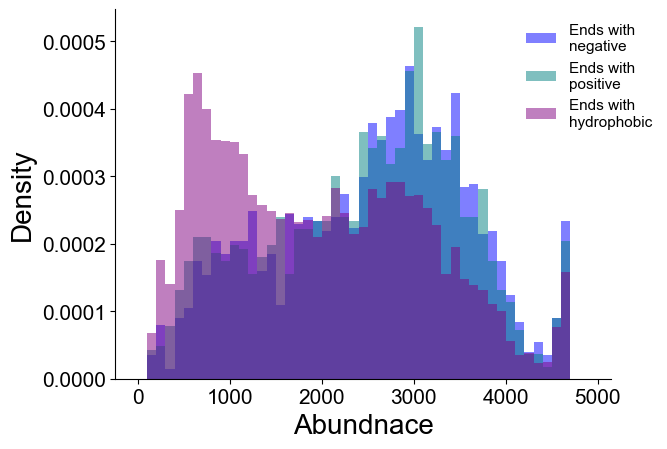

In [120]:
bins = np.arange(0, 5000, 100)

plt.hist(data[data["ends_w_negative"]]["abundance"], density=True, alpha=0.5, bins=bins, color="blue", label="Ends with \nnegative")
plt.hist(data[data["ends_w_positive"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \npositive")
plt.hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \nhydrophobic")
plt.xlabel("Abundnace", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=11, bbox_to_anchor=(0.8,1), frameon=False)

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_histograms_pos_negative.pdf", format='pdf', bbox_inches='tight')


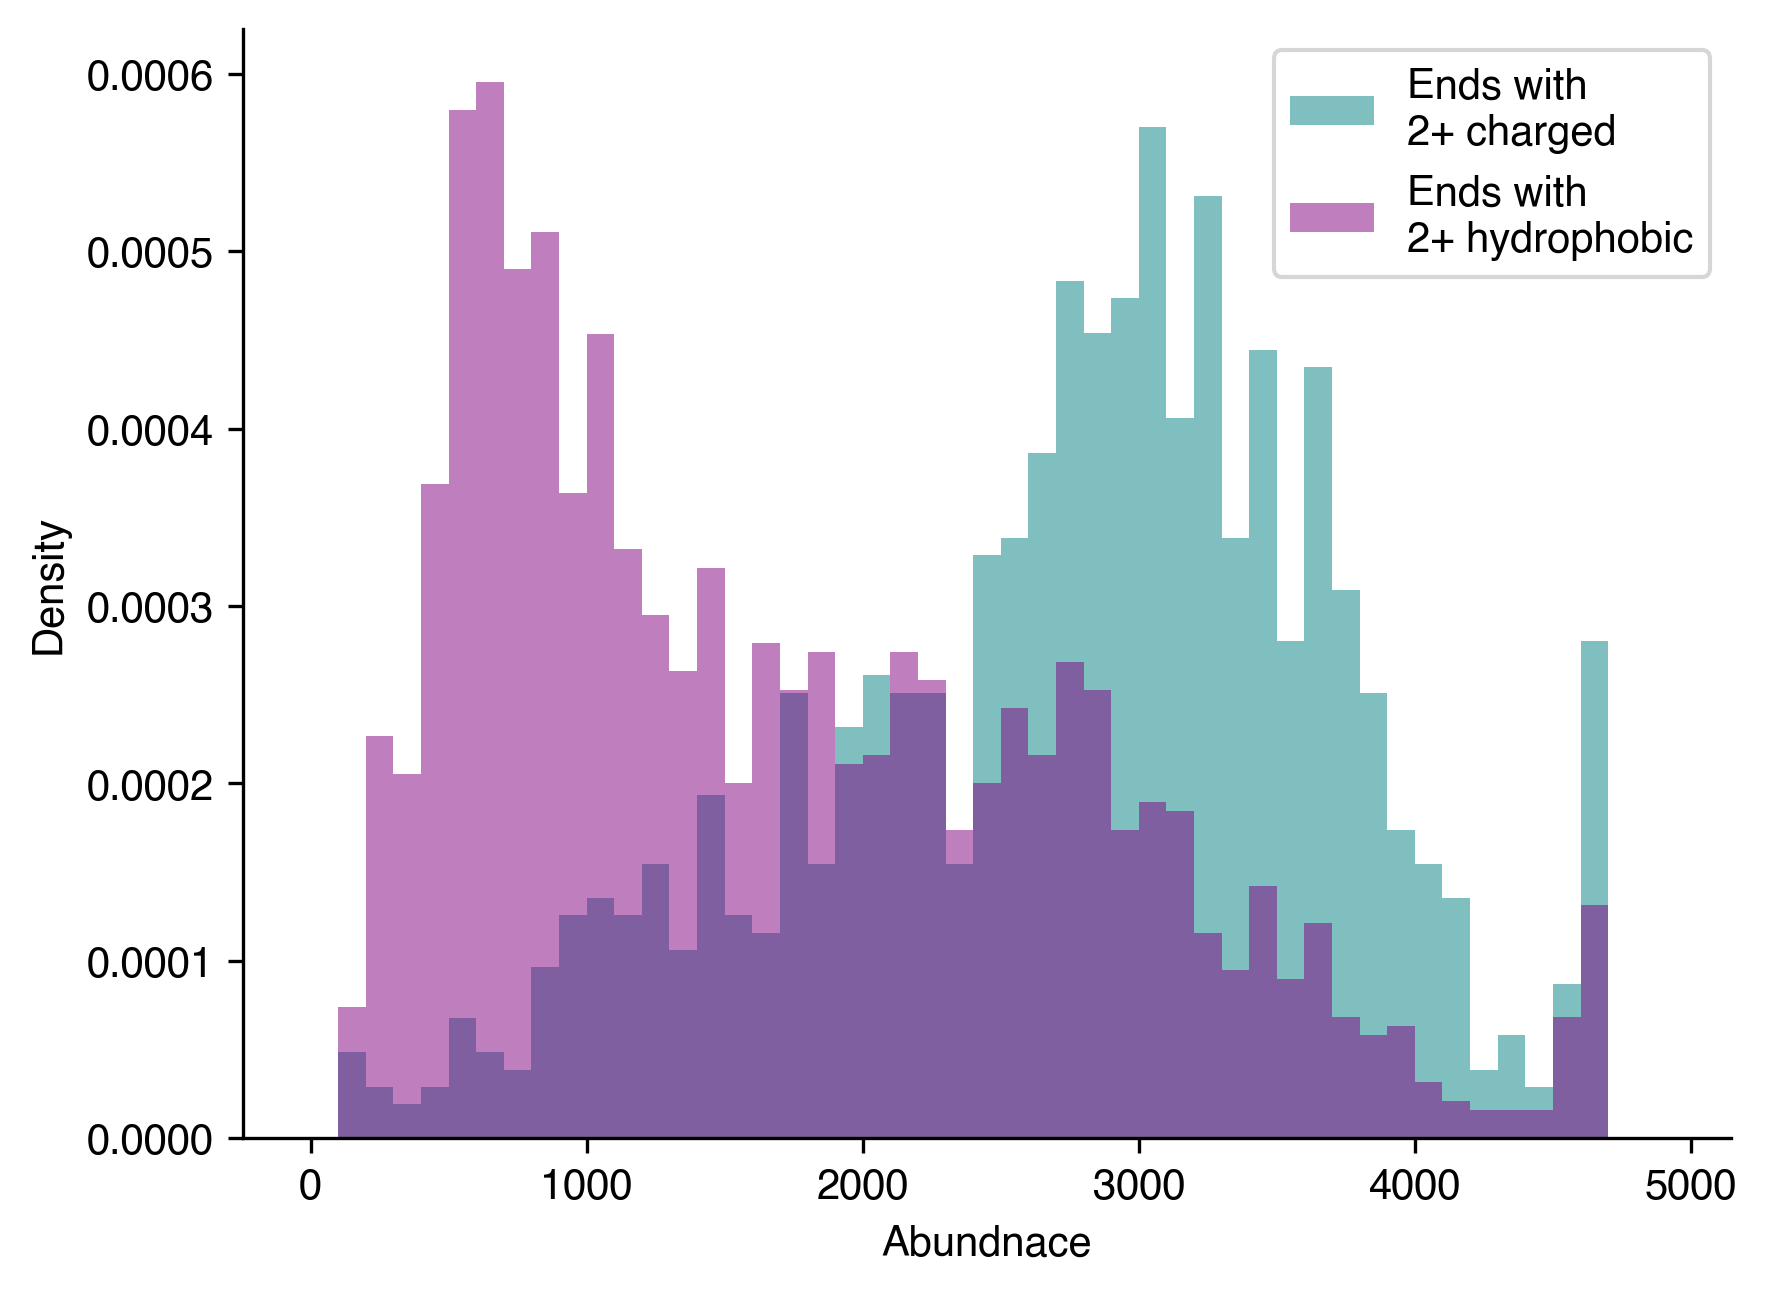

In [71]:
bins = np.arange(0, 5000, 100)
plt.hist(data[data["ends_w_two_charge"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \n2+ charged")
plt.hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \n2+ hydrophobic")
plt.xlabel("Abundnace")
plt.ylabel("Density")
plt.legend()

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

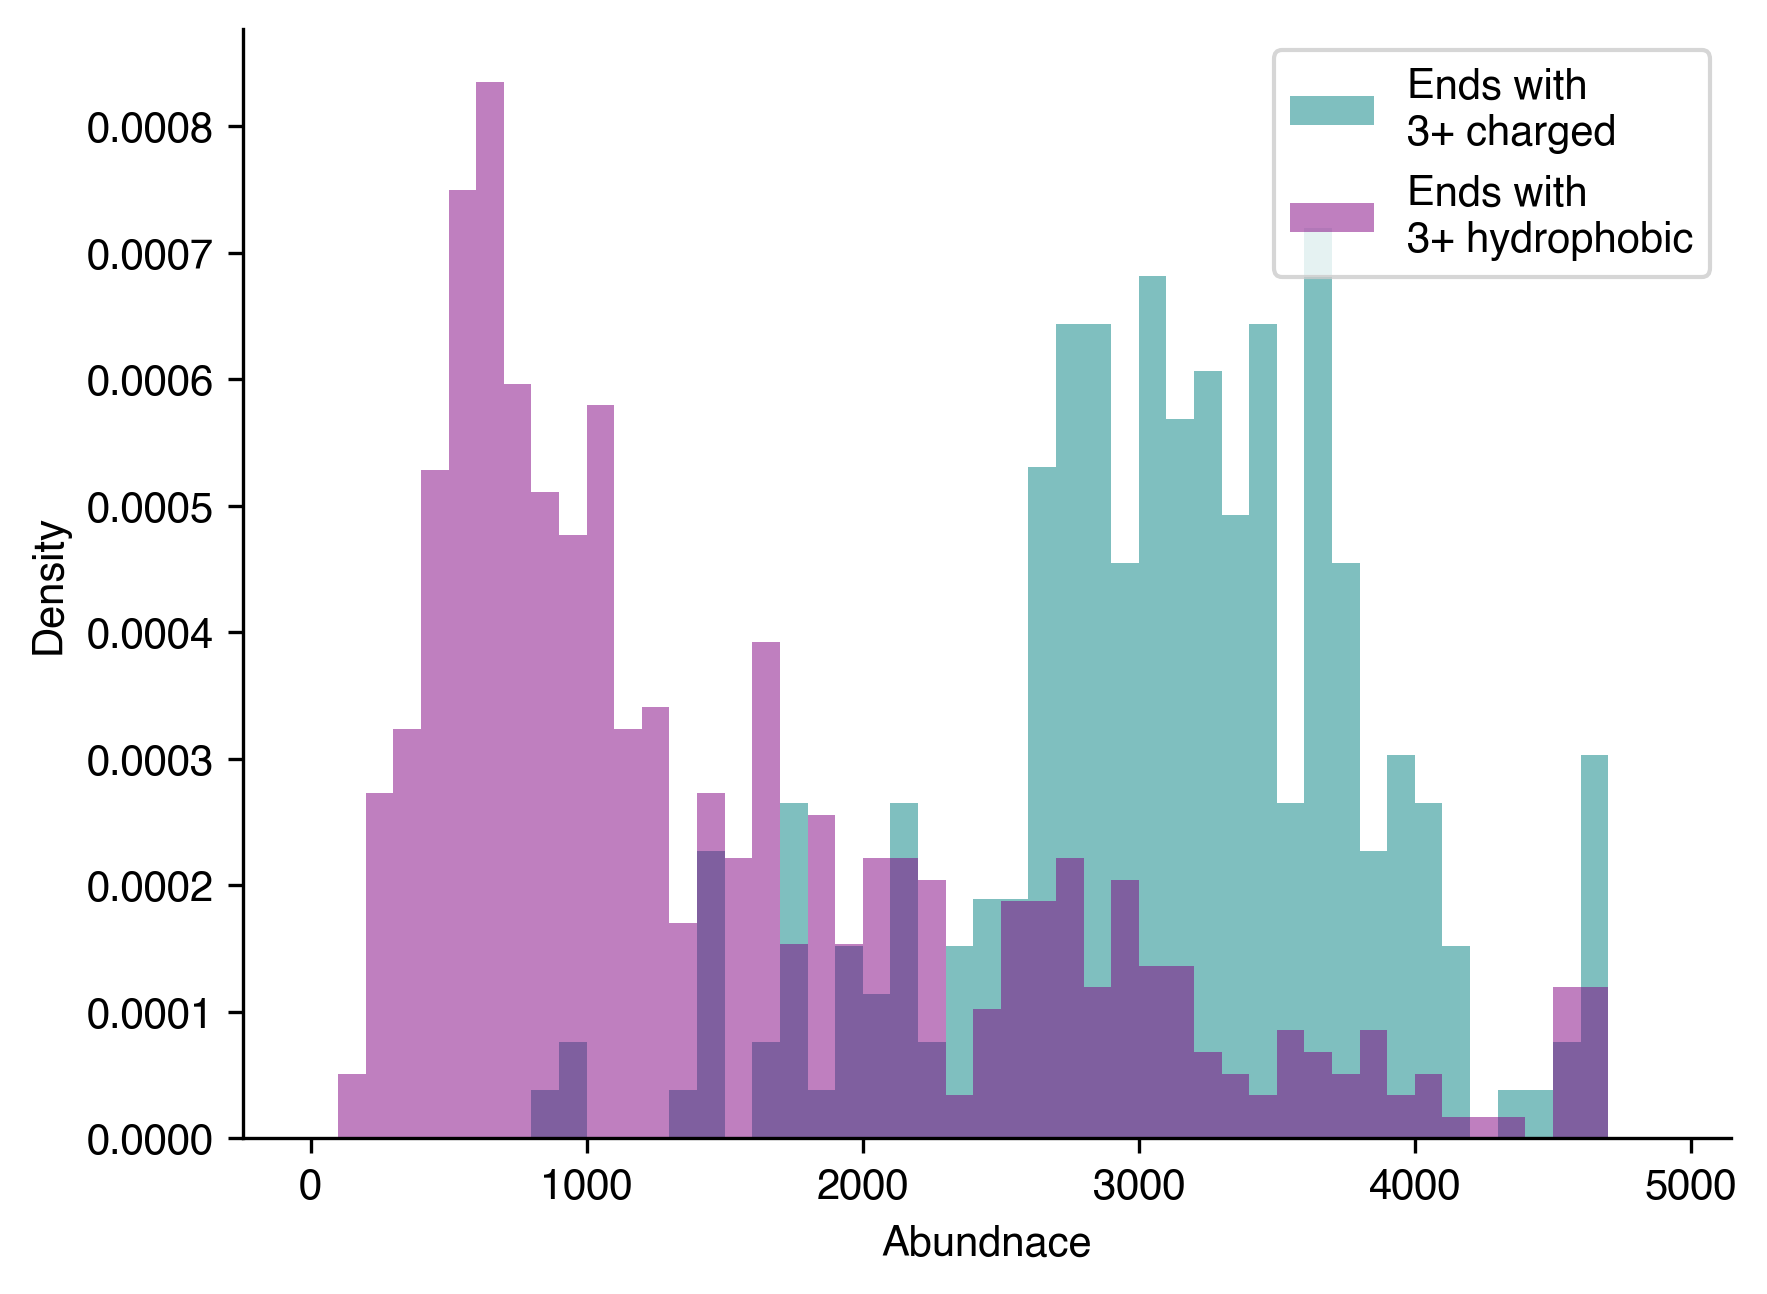

In [72]:
bins = np.arange(0, 5000, 100)
plt.hist(data[data["ends_w_three_charge"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \n3+ charged")
plt.hist(data[data["ends_w_three_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \n3+ hydrophobic")
plt.xlabel("Abundnace")
plt.ylabel("Density")
plt.legend()

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

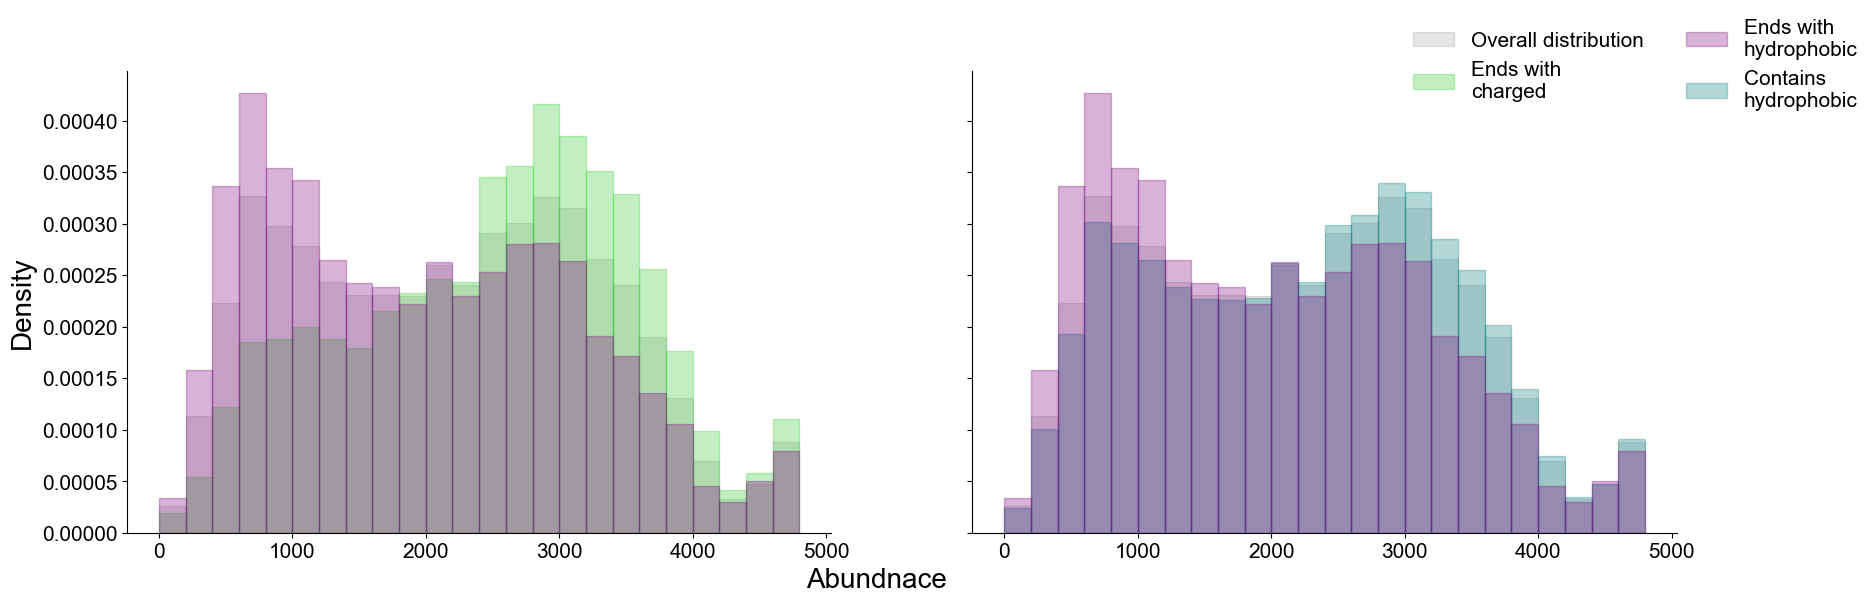

In [104]:
bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \ncharged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nhydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains \nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nhydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_one_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_one_hydrophobic.png", format='png', bbox_inches='tight')


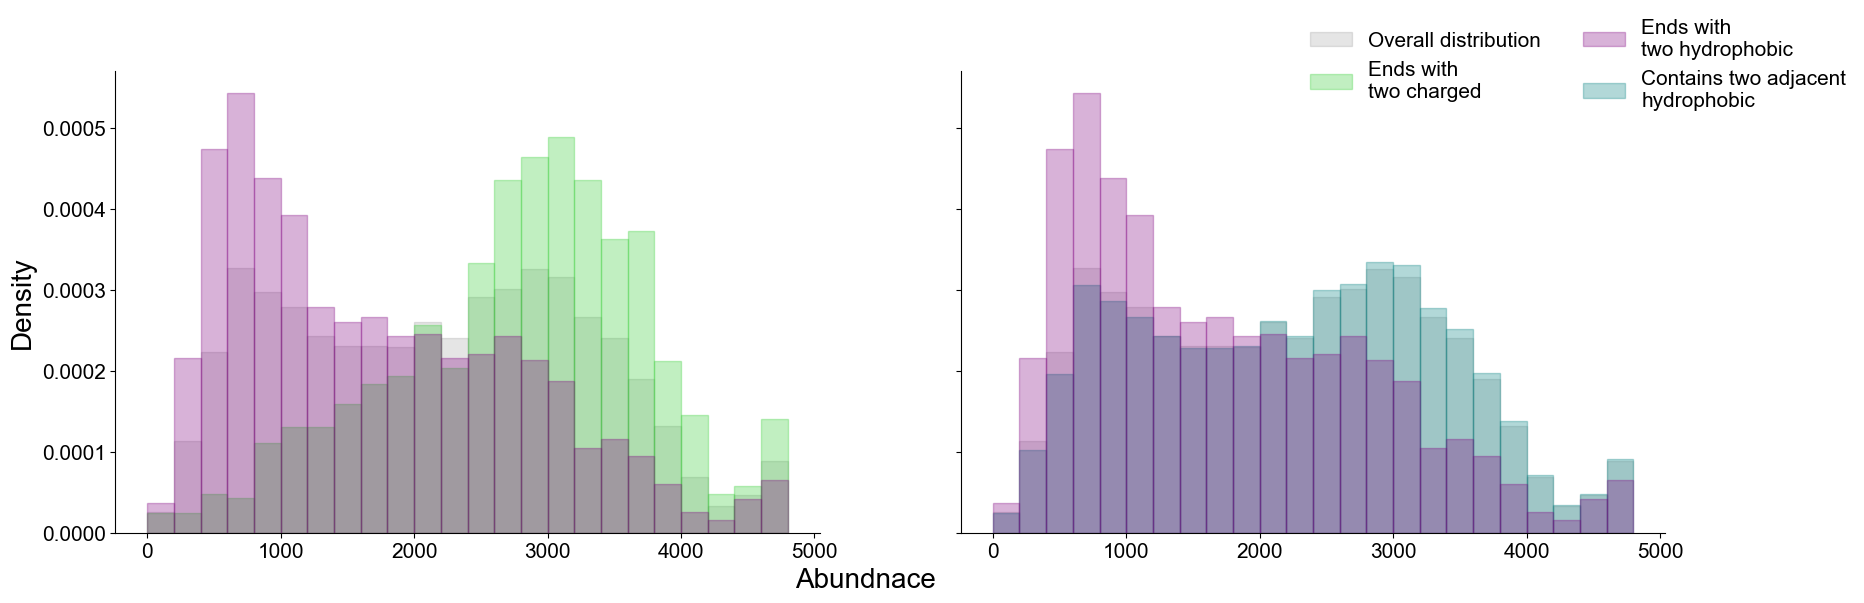

In [103]:
bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_two_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \ntwo charged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \ntwo hydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_two_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains two adjacent\nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \ntwo hydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_two_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_two_hydrophobic.png", format='png', bbox_inches='tight')


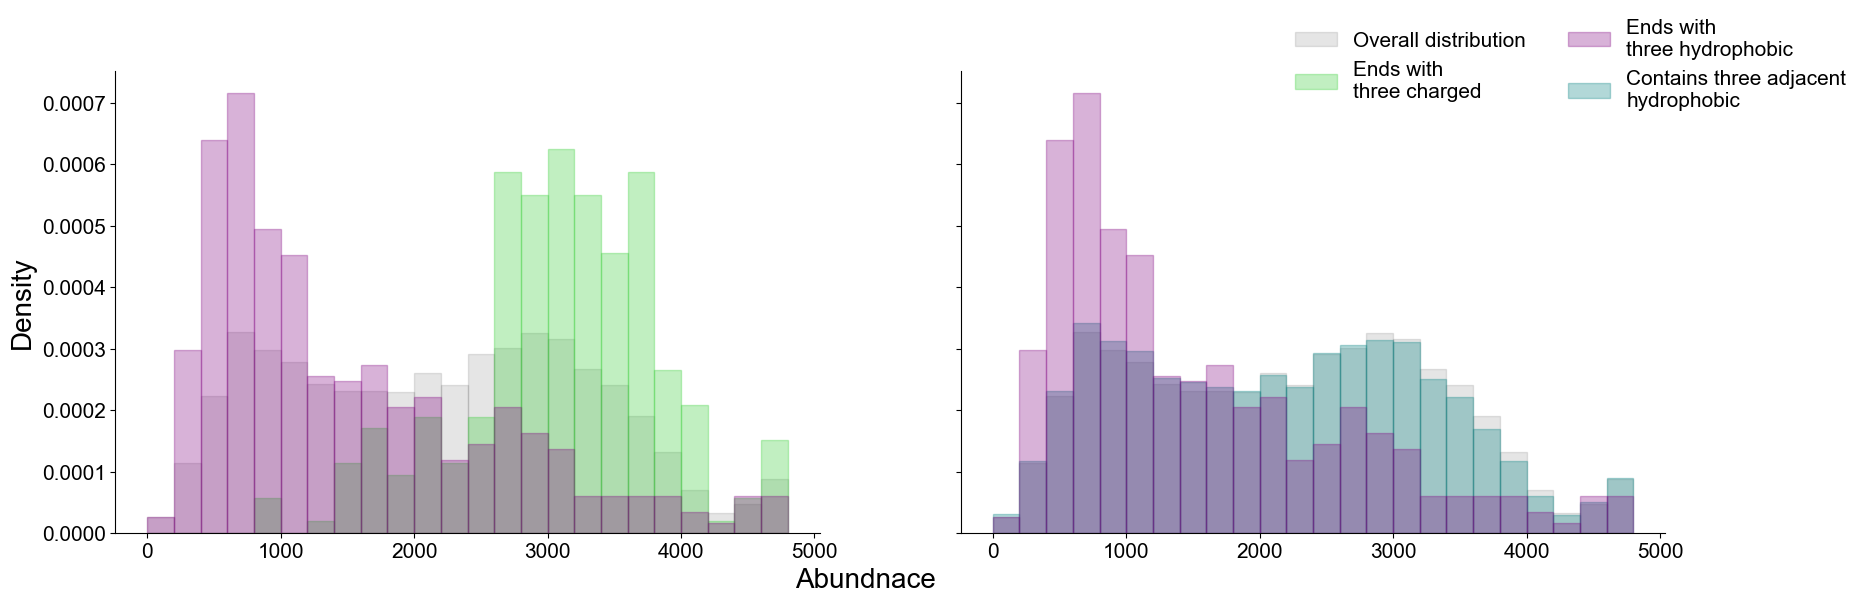

In [101]:
bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_three_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \nthree charged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_three_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nthree hydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_three_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains three adjacent\nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_three_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nthree hydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_three_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_three_hydrophobic.png", format='png', bbox_inches='tight')


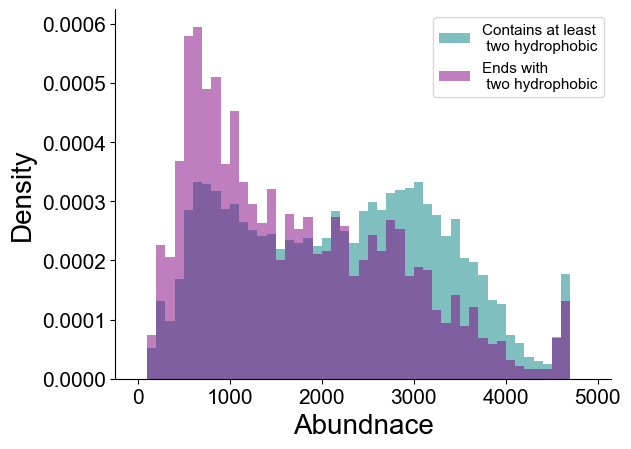

In [8]:
bins = np.arange(0, 5000, 100)
plt.hist(data[data["contains_two_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Contains at least\n two hydrophobic")
plt.hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \n two hydrophobic")
plt.xlabel("Abundnace", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=11)

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig("figures/abundance_histograms.pdf", format='pdf', bbox_inches='tight')


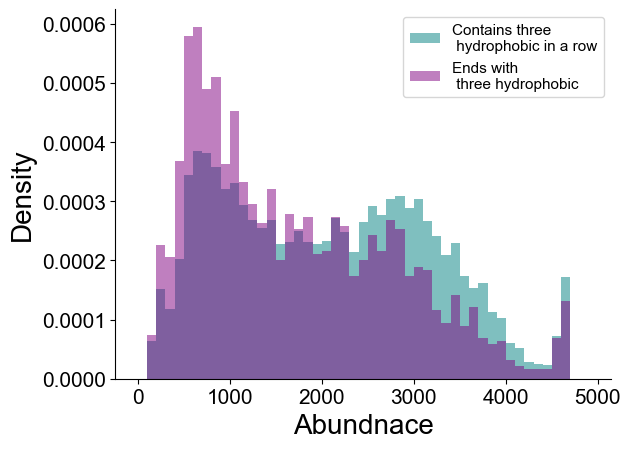

In [10]:
bins = np.arange(0, 5000, 100)
plt.hist(data[data["contains_three_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Contains three\n hydrophobic in a row")
plt.hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \n three hydrophobic")
plt.xlabel("Abundnace", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=11)

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig("figures/abundance_histograms.pdf", format='pdf', bbox_inches='tight')


# Looking in actual sequences

In [59]:
def read_fasta(file):
    with open(file, "r") as f:
        lines = f.readlines()

    seq = ""
    names = []
    seqs = []

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">", ""))
            if len(names) > 1:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    return pd.DataFrame({"aa_seq": seqs, "name" : names})

In [62]:
war1 = read_fasta("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/War1_ygob.fasta")
war1["ends"] = war1["aa_seq"].str[-2] 

In [55]:
pdr1 = read_fasta("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Pdr1_ygob.fasta")
pdr1["ends"] = pdr1["aa_seq"].str[-2] 

In [65]:
ppr1 = read_fasta("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Ppr1_ygob.fasta")
ppr1["ends"] = ppr1["aa_seq"].str[-2] 

In [63]:
# Galactose response
gal4 = read_fasta("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Gal4_ygob.fasta")
gal4["ends"] = gal4["aa_seq"].str[-2] 

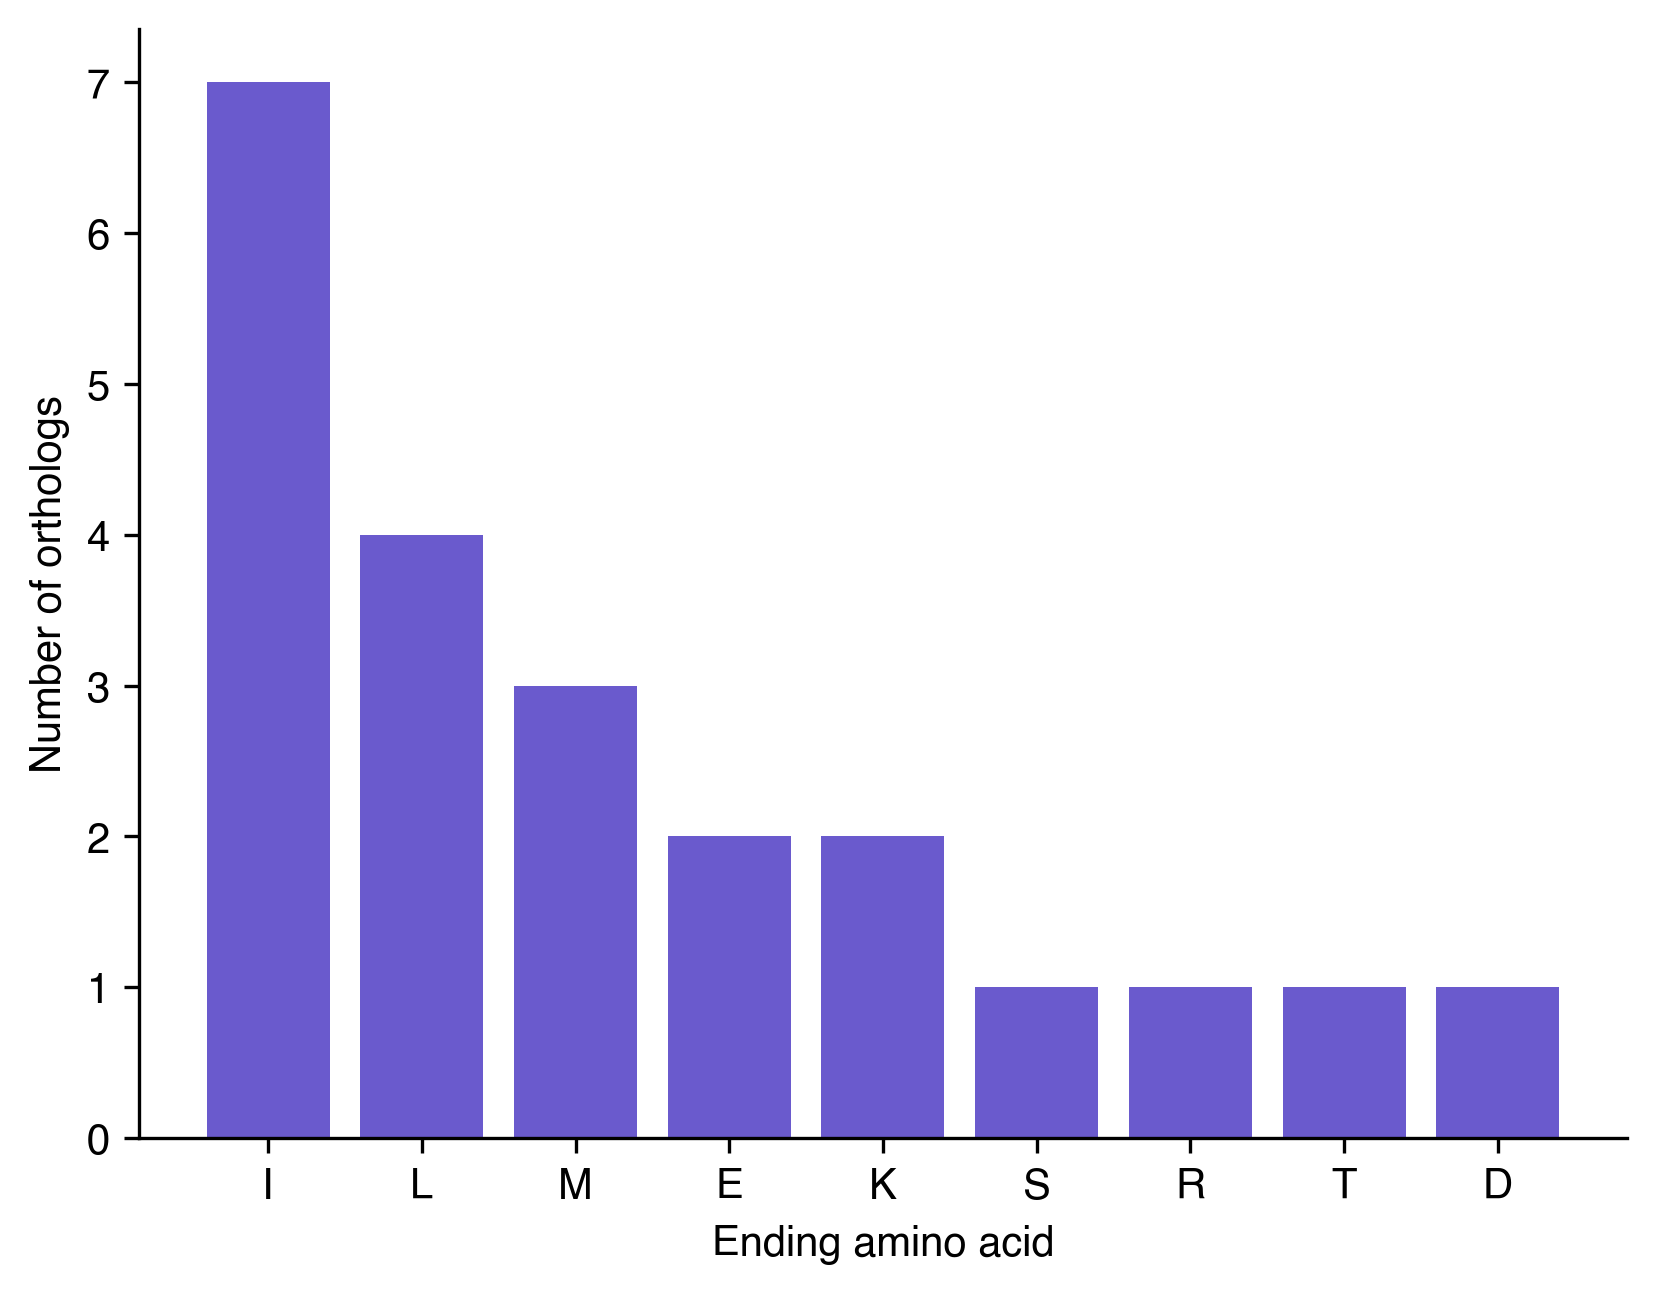

In [70]:
plt.bar(war1["ends"].value_counts().index, height=war1["ends"].value_counts(), color="slateblue")
plt.ylabel("Number of orthologs")
plt.xlabel("Ending amino acid")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [101]:
war1["hydrophobic"] = [b in hydrophobics for b in war1["ends"]]
pdr1["hydrophobic"] = [b in hydrophobics for b in pdr1["ends"]]
gal4["charged"] = [(b in positives) | (b in negatives) for b in gal4["ends"]]
gal4["hydrophobic"] = [b in hydrophobics for b in gal4["ends"]]

In [76]:
war1["hydrophobic"].sum() / len(war1["hydrophobic"])

0.6363636363636364

In [94]:
pdr1["hydrophobic"].sum() / len(pdr1["hydrophobic"])

0.42857142857142855

In [102]:
gal4["hydrophobic"].sum() / len(gal4["charged"])

0.17647058823529413

In [90]:
def hydrophobic_percentage(seq):
    count = 0
    for s in seq[-30:]:
        if s in hydrophobics:
            count +=1
    return count / len(seq[-30:])

In [96]:
def negative_percentage(seq):
    count = 0
    for s in seq[-30:]:
        if s in negatives:
            count +=1
    return count / len(seq[-30:])

In [91]:
war1["hydrophobic_percentage"] = [hydrophobic_percentage(s) for s in war1["aa_seq"]]

In [103]:
gal4["hydrophobic_percentage"] = [hydrophobic_percentage(s) for s in gal4["aa_seq"]]

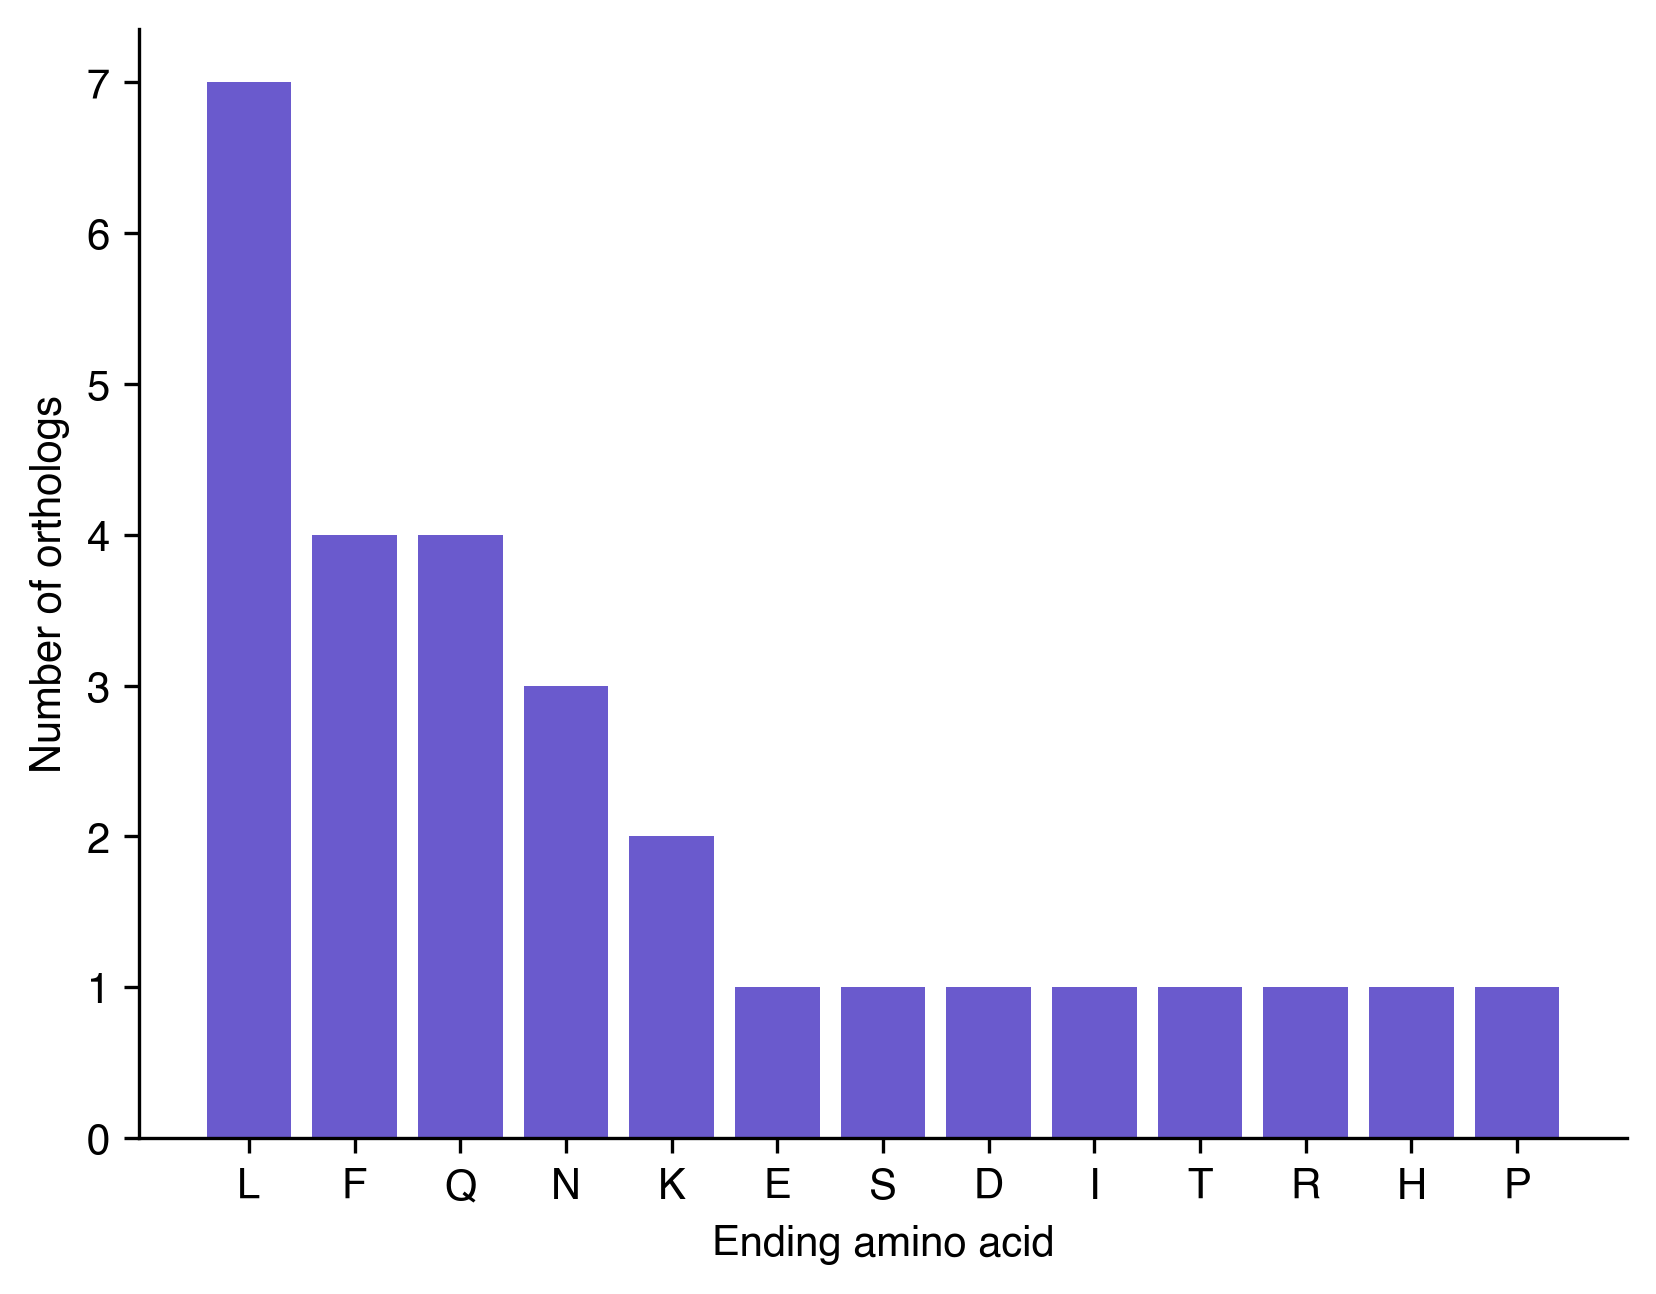

In [69]:
# master regulator of multidrug resistance genes
plt.bar(pdr1["ends"].value_counts().index, height=pdr1["ends"].value_counts(), color="slateblue")
plt.ylabel("Number of orthologs")
plt.xlabel("Ending amino acid")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

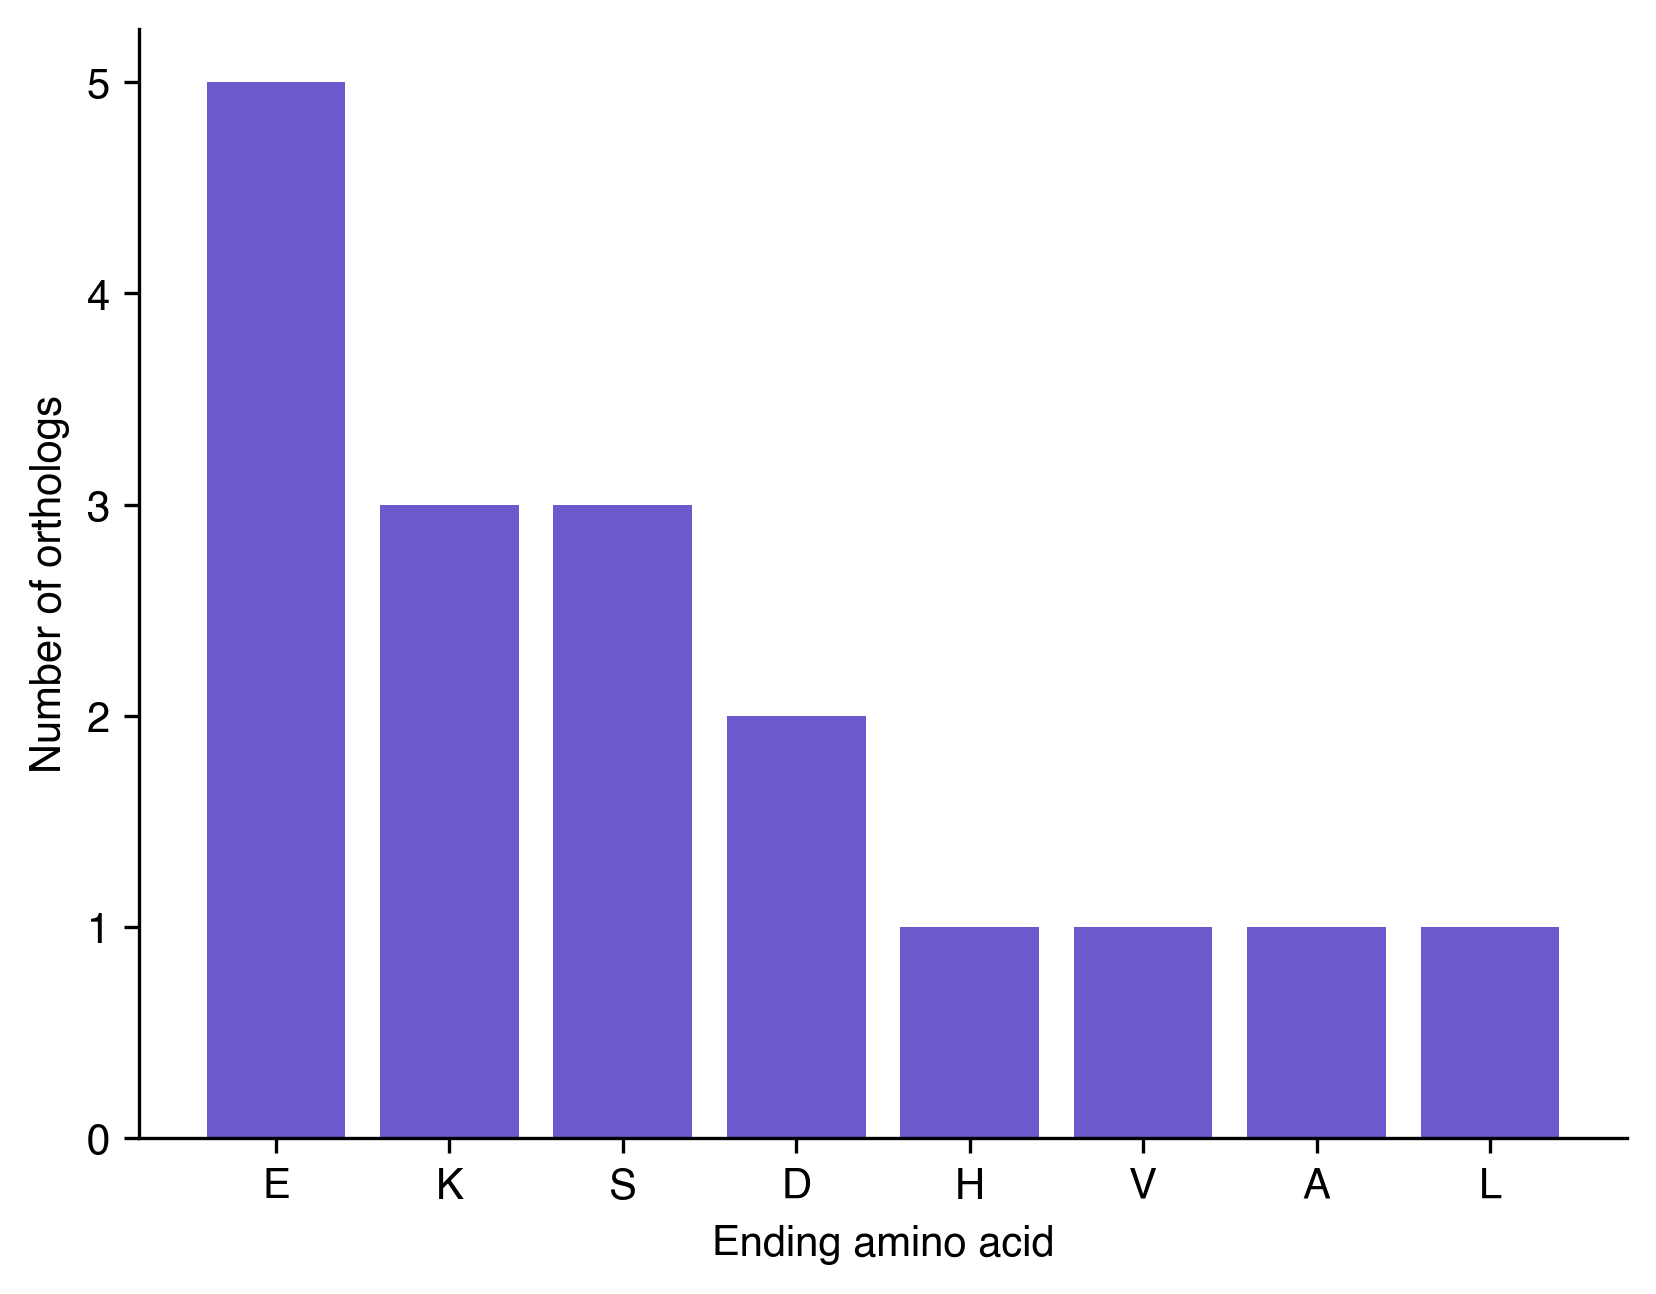

In [95]:
# master regulator of multidrug resistance genes
plt.bar(gal4["ends"].value_counts().index, height=gal4["ends"].value_counts(), color="slateblue")
plt.ylabel("Number of orthologs")
plt.xlabel("Ending amino acid")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

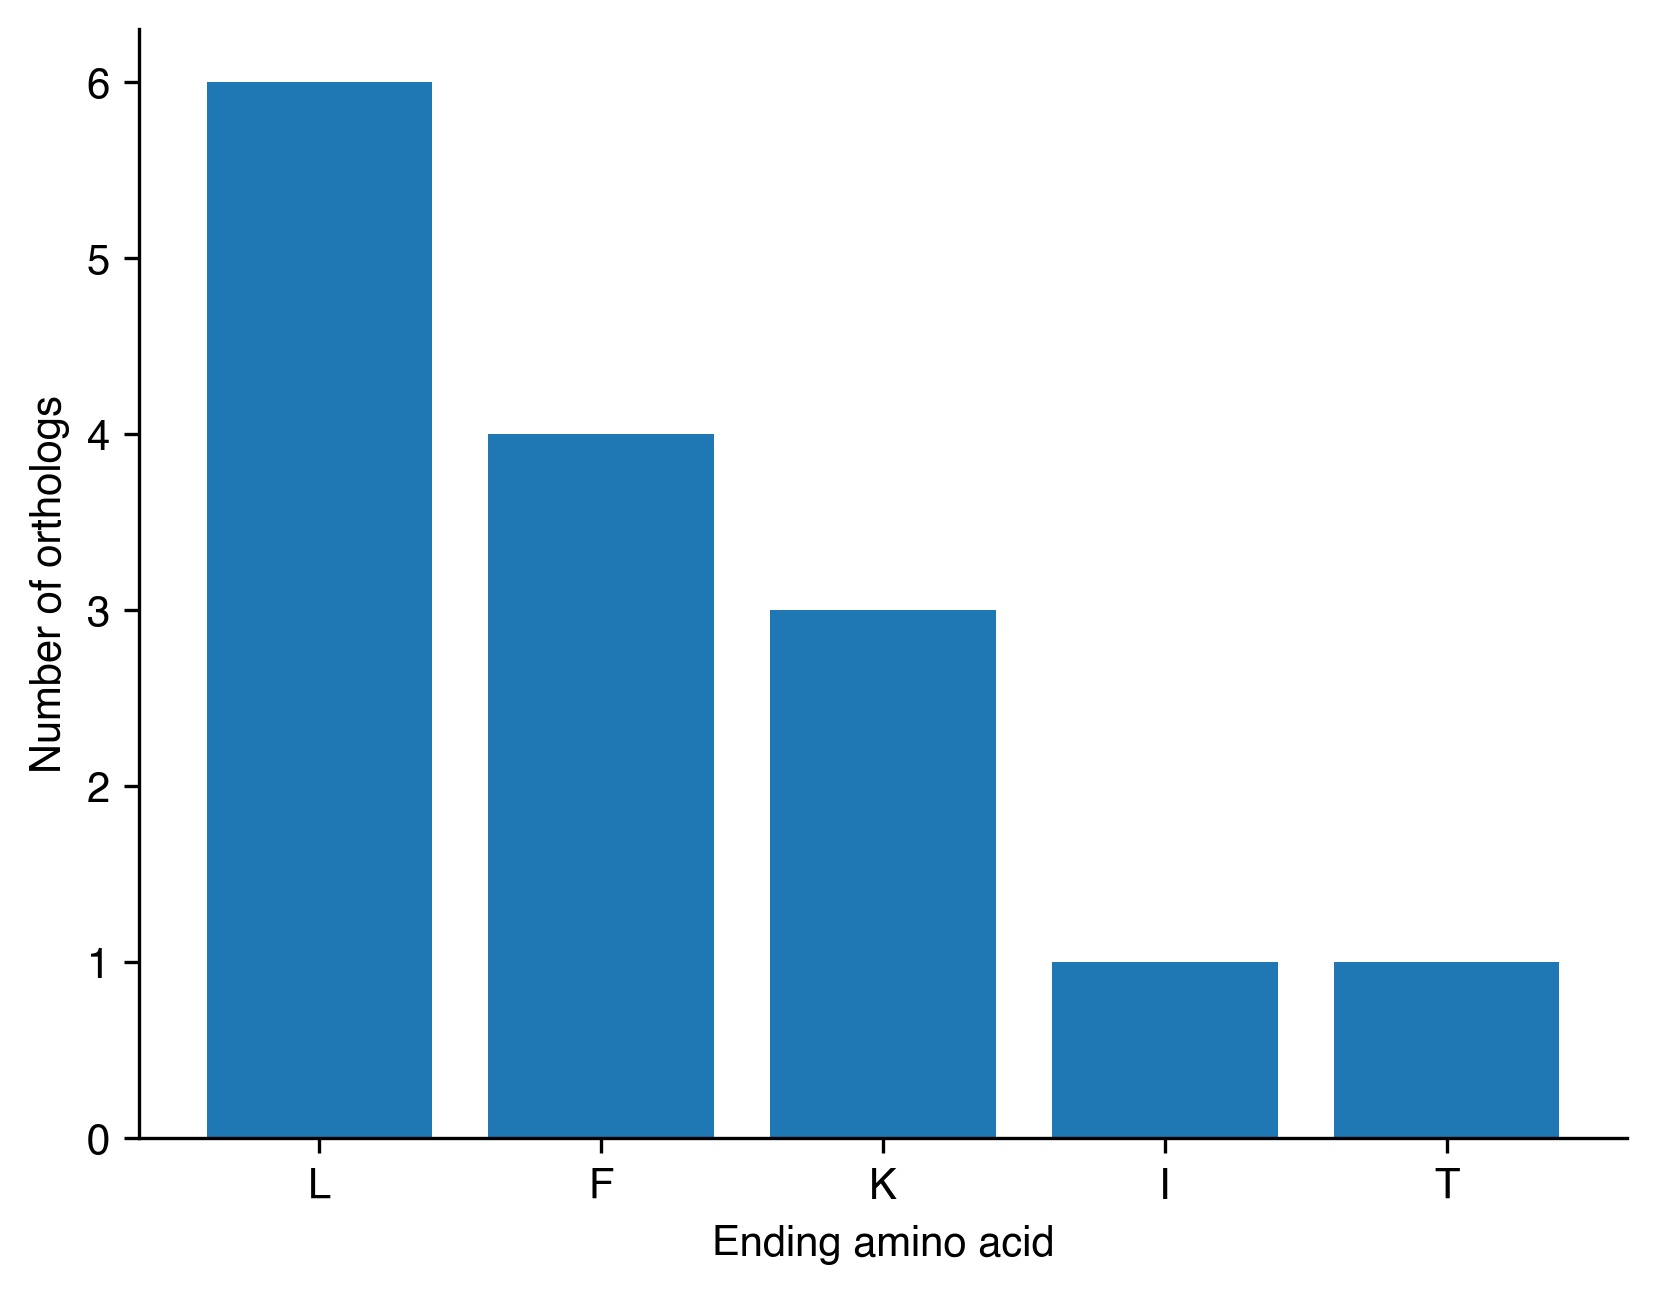

In [66]:
# master regulator of multidrug resistance genes
plt.bar(ppr1["ends"].value_counts().index, height=ppr1["ends"].value_counts())
plt.ylabel("Number of orthologs")
plt.xlabel("Ending amino acid")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [104]:
gal4

,aa_seq,name,ends,charged,hydrophobic,hydrophobic_percentage
0,MKVLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...,"Smik_6.452 Chr6 (741922..744558) [2637 bp, 878...",E,True,False,0.333333
1,MSIVTLMKDTSLLNDQACDSCRLKKLKCSKEKPKCAKCLKNIWECC...,TBLA0G01800 Chr7 complement(469668..473132) [3...,K,True,False,0.200000
2,MPRIPGVVDQACDSCRIKKLRCSKENPKCAKCLKNKWECCYSPRKR...,"TPHA0H01980 Chr8 (467688..470669) [2982 bp, 99...",D,True,False,0.433333
3,MTPIVQQACDSCRKRKLRCSKELPKCSKCLKHNWECCYSPKAVRSP...,SAKL0A02860g Chr1 complement(259388..261625) [...,S,False,False,0.300000
4,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...,YPL248C Chr16 complement(79711..82356) [2646 b...,E,True,False,0.266667
5,MGSRASNSPSFSSKAETLLPSEYKKNAVKKETIRNGKKRKLPDTES...,KLLA0D12672g Chr4 complement(1076011..1078608)...,E,True,False,0.333333
6,MSNIITNQVCDSCRLKKLKCSKEKPKCFKCLKHNWECNYSPKIKRS...,"Kpol_1018.30 s1018 complement(81534..83840,838...",E,True,False,0.366667
7,MKLLPAMEQACDICRLKKLKCSKEKPKCSKCLKNNWECCYSPKTKR...,Suva_16.59 Chr16 complement(88631..91318) [268...,E,True,False,0.300000
8,MRYPFIPNSDQACDLCRVKKLKCSKEKPKCAKCLKNNWECCYSPKT...,NCAS0G01100 Chr7 complement(193052..195859) [2...,K,True,False,0.266667
9,MIRMKEEESRHHANSSTDQACDLCRIKKLKCSKDKPACRKCAKNGW...,"KNAG0D00690 Chr4 (105640..108267) [2628 bp, 87...",D,True,False,0.233333
